# IMDB Point Prediction with Random Forests

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

sns.set(color_codes=True)
sns.set(style="ticks")

data_frame_original = pd.read_csv("movie_metadata.csv")
#data_frame.loc[data_frame['imdb_score'] >= 7.5, 'imdb_score'].size / data_frame['imdb_score'].count()


In [12]:
imdb_score_limit = 7.5

data_frame = data_frame_original.copy()
data_frame = data_frame.drop('genres',axis=1);
data_frame = data_frame.drop('plot_keywords',axis=1);
data_frame = data_frame.drop('movie_imdb_link', axis=1)
data_frame = data_frame.drop('movie_title',axis=1)
#data_frame = data_frame.drop('movie_facebook_likes',axis=1)
#data_frame.loc[data_frame['imdb_score'] < imdb_score_limit, 'imdb_score'] = 0
#data_frame.loc[data_frame['imdb_score'] >= imdb_score_limit, 'imdb_score'] = 1
data_frame


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Daryl Sabara,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,J.K. Simmons,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Brad Garrett,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Chris Hemsworth,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Alan Rickman,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


In [13]:

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

for column_name in data_frame.columns:
    le = LabelEncoder()
    column = data_frame[column_name]
    try:
        if column_name == 'plot_keywords' or column_name == 'genres':
            mlb = MultiLabelBinarizer()
            keywords = list()
            column.fillna('UNKNOWN')
            column.apply(lambda x: keywords.append(x.split('|')) if x is not np.nan else keywords.append(['UNKNOWN']))
            binarized = mlb.fit_transform(keywords)
            plt.imshow(binarized)
            class_values = pd.Series(list(binarized))
            data_frame[column_name].update(class_values)

        else:
            normalized_column = column.fillna(0) if column.dtype.kind in 'biufc' else column.fillna('UNKNOWN')
            class_values = normalized_column if column.dtype.kind in 'biufc' else pd.Series(list(le.fit_transform(normalized_column))) 
            data_frame[column_name].update(class_values)
    except:
        pass

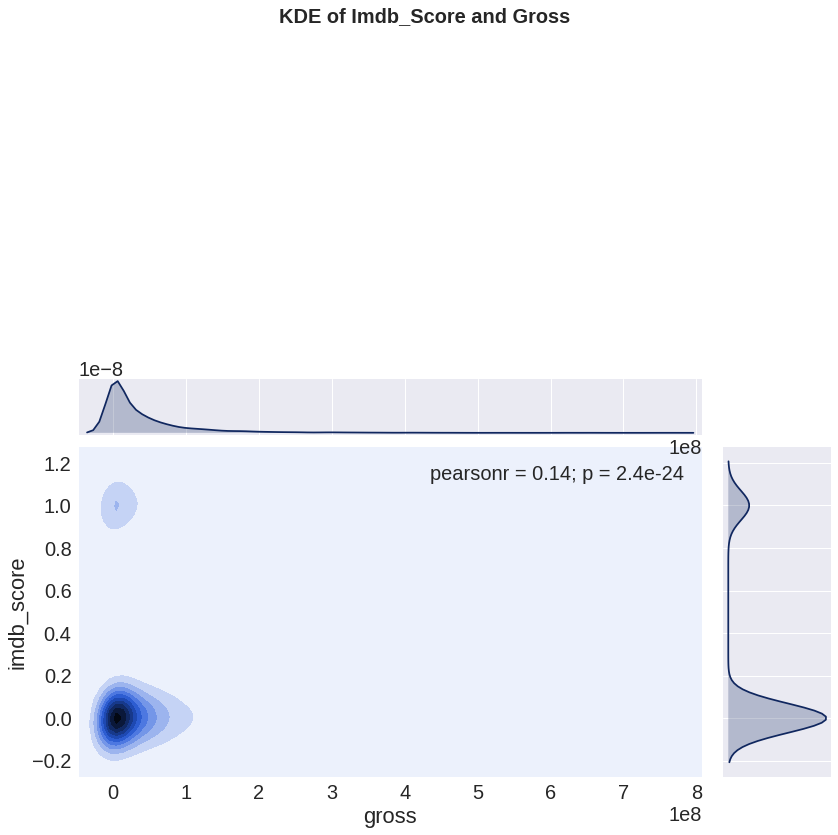

In [297]:
# Figures for representing some features
sns.set(font_scale = 2)
g = sns.jointplot('gross', 'imdb_score', size=12, data=data_frame, kind="kde", color="#10275F")
plt.subplots_adjust(top=0.55)
g.fig.suptitle('KDE of Imdb_Score and Gross', size=20, weight='bold')
sns.set(font_scale = 1)
# This is different from the kaggle kernel result(as in shape)

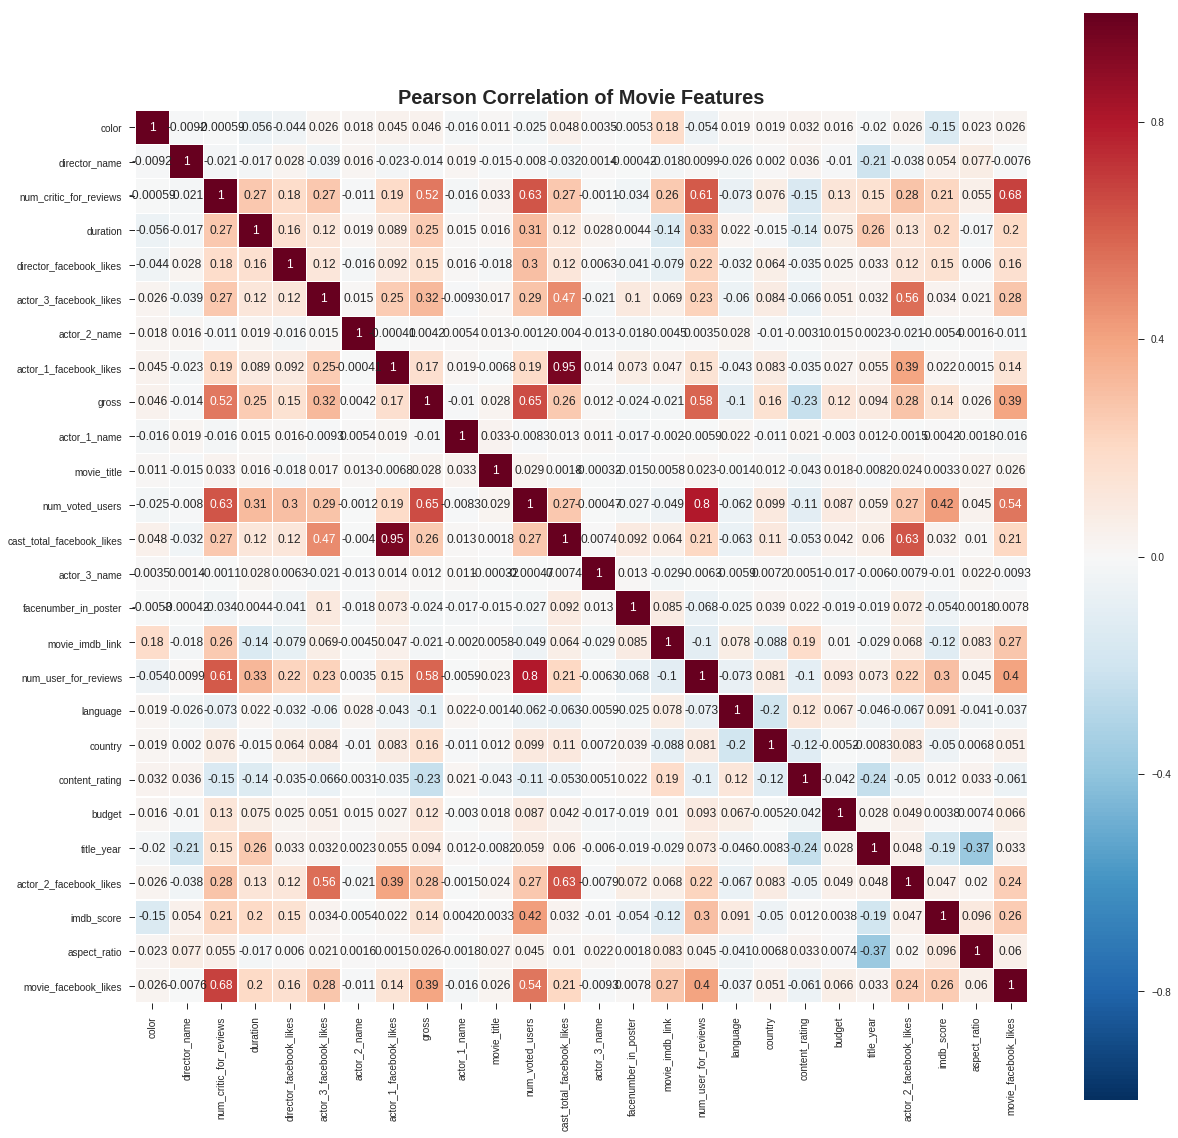

In [239]:
# Showing the pearson correlation of features
with sns.plotting_context(font_scale=1.25):
    f, ax = plt.subplots(figsize=(20, 20))
    plt.title('Pearson Correlation of Movie Features', {'weight': 'bold', 'size': 20})
    # plot_keywords features are encoded as array which requires more care to plot in this way
    
    sns.heatmap(data_frame.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True, annot=True)

Create training and test datasets with .75 probab.

In [6]:

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

data_frame_temp = data_frame.copy()
class0 = data_frame_temp[data_frame_temp['imdb_score']==0]
class1 = data_frame_temp[data_frame_temp['imdb_score']==1]
train0, test0, ign1, ign2 = train_test_split(class0,class0['imdb_score'], test_size=0.4)
train1, test1, ign1, ign2 = train_test_split(class1,class1['imdb_score'], test_size=0.4)
train = pd.concat([train0,train1])
test = pd.concat([test0,test1])

Select features to use in the training, and the target class to predict

In [7]:
## select the features
features = data_frame.columns
train_feat = features[features != 'imdb_score']
train_results = train.imdb_score

Fit the model to RandomForestClassifier with the training data

Get the results of the model for the test class and give the precision

In [11]:
#print(len(set(data_frame.actor_1_name)))
clf = RandomForestClassifier(n_jobs=-1,bootstrap=True, n_estimators=25)

clf.fit(train[train_feat], train_results);


prediction = clf.predict(test[train_feat])


result =  test.imdb_score - prediction

#pd.crosstab(test['imdb_score'], prediction, rownames=['Actual Imbd >= 7.5'], colnames=['Predicted Imdb >= 7.5'])
#list(zip(train[features], clf.feature_importances_))

from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


print(classification_report(test.imdb_score,prediction))
print(confusion_matrix(test.imdb_score,prediction))

             precision    recall  f1-score   support

        0.0       0.90      0.98      0.94      1663
        1.0       0.83      0.51      0.63       355

avg / total       0.89      0.90      0.88      2018

[[1627   36]
 [ 175  180]]


## Random Forest Regression

In [16]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestRegressor

data_frame_temp = data_frame.copy()
train, test, ign1, ign2 = train_test_split(data_frame_temp,data_frame_temp['imdb_score'], test_size=0.25)

Select features to use in the training, and the target class to predict

In [17]:
## select the features
features = data_frame.columns
train_results = train.imdb_score

Fit the model to RandomForestRegressor with the training data

Get the results of the model for the test class and give the precision

In [25]:
#print(len(set(data_frame.actor_1_name)))
clf = RandomForestRegressor(n_jobs=-1,bootstrap=True, n_estimators=25)

clf.fit(train[train_feat], train_results);


prediction = clf.predict(test[train_feat])

print(prediction)
result =  test.imdb_score - prediction

#pd.crosstab(test['imdb_score'], prediction, rownames=['Actual Imbd >= 7.5'], colnames=['Predicted Imdb >= 7.5'])
#list(zip(train[features], clf.feature_importances_))

from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

print(mean_squared_error(test.imdb_score,prediction))
print(explained_variance_score(test.imdb_score,prediction))

[ 5.732  5.968  5.764 ...,  6.356  6.328  6.556]
0.667598553529
0.465926874736
